In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.nn import Sequential, ReLU, Linear, Conv1d, LSTM, RNN, Dropout
from torch.nn import Module
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor   
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from NCP.model import DeepSVD
from NCP.layers import SingularLayer, MLPOperator

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 1000
Nval = 1000
Ntest = 1000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
X = np.random.uniform(-5, 5, Ntrain+Nval+Ntest)
Y = 5*X+3 + np.random.normal(0, 1, X.shape[0])

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()
# Xtransformed = X - X.mean()
# Ytransformed = Y - Y.mean()

Xtransformed = xscaler.fit_transform(X)
Ytransformed = yscaler.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(Xtransformed, Ytransformed, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

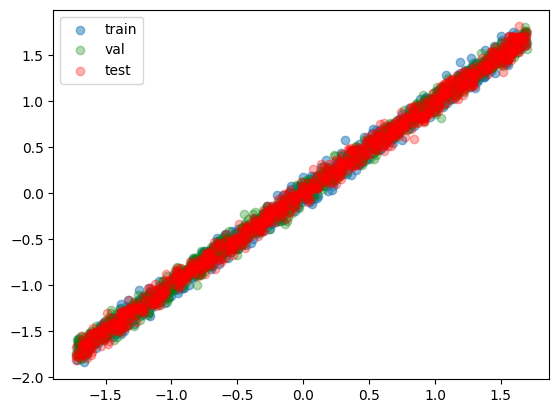

In [4]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [12]:
np.random.seed(0)
torch.manual_seed(0)

input_shape = X_train.shape[-1]
output_shape = 2
n_hidden = 0
layer_size = 16 # layer size of hidden layers.

U_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)
V_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': 1e-3
    }
reg = (DeepSVD(U_operator, V_operator, output_shape, gamma=0))

In [13]:
reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(2e3), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

epoch = 1999, loss = -2.0698297023773193: 100%|██████████| 2000/2000 [00:06<00:00, 299.04it/s]


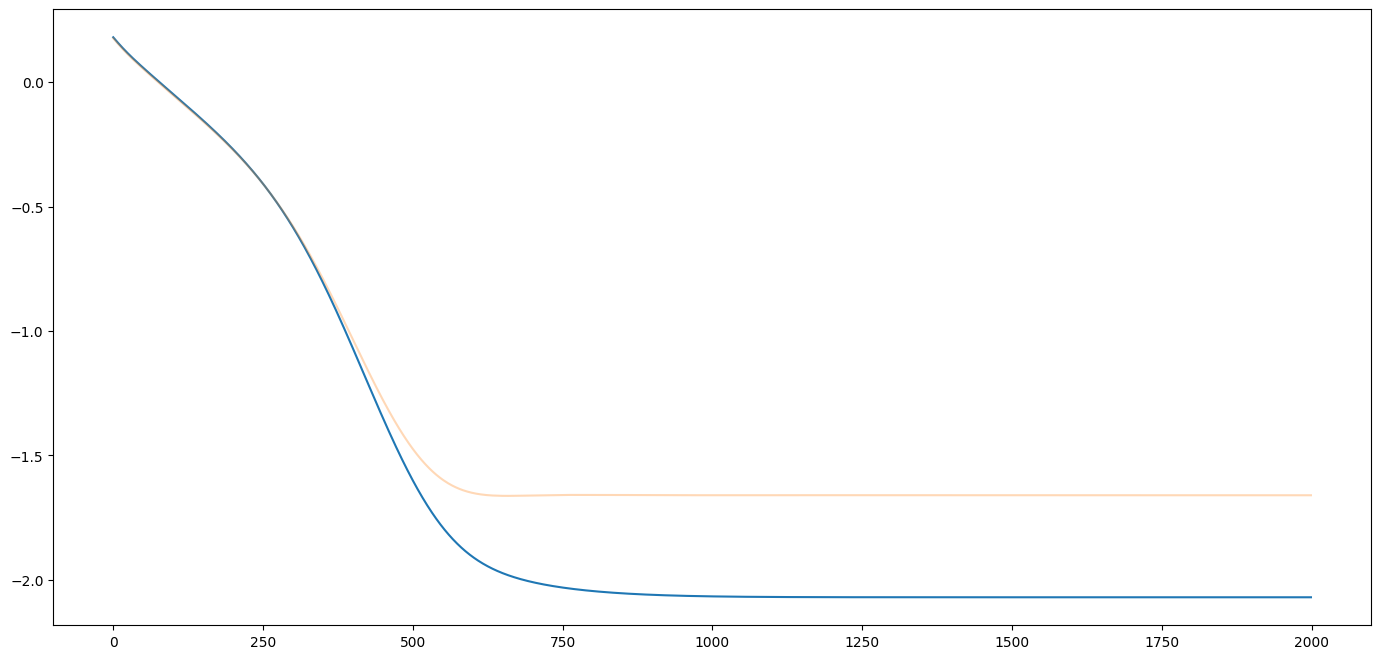

In [14]:
ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

U(x) [[ 1.080779   -1.3954893 ]
 [-0.30668977  0.3959943 ]
 [ 0.7769301  -1.0031632 ]
 ...
 [-0.8070119   1.0420045 ]
 [-1.0314283   1.3317684 ]
 [ 0.41508603 -0.5359543 ]]
V(y) [[ 1.5702296  -0.92512167]
 [-0.47335237  0.27888182]
 [ 1.0588887  -0.62385833]
 ...
 [-1.1037427   0.65028465]
 [-1.4941014   0.8802697 ]
 [ 0.7026876  -0.41399774]]
fY [[-1.76794964 -1.76794964]
 [ 0.56904434  0.56904434]
 [-1.1831916  -1.1831916 ]
 ...
 [ 1.28994441  1.28994441]
 [ 1.73634977  1.73634977]
 [-0.77584815 -0.77584815]]
VyfY [-0.84819262  0.49972393]


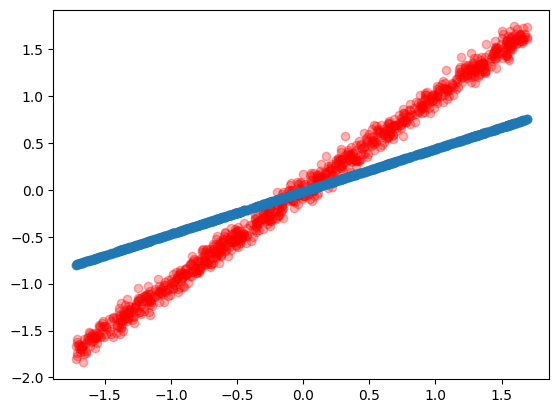

In [15]:
pred = reg.predict(X_train).reshape(-1, 1)

plt.scatter(X_train, Y_train, color='r', alpha=0.3)
plt.scatter(X_train, pred, alpha=0.5)
plt.show()

In [16]:
reg.models['U']

MLPOperator(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
  )
)

In [17]:
Ux = reg.models['U'](torch.Tensor(X_train))
Vy = reg.models['V'](torch.Tensor(Y_train))

In [18]:
cov_X = Ux.T @ Ux / X_train.shape[0]
cov_Y = Vy.T @ Vy / X_train.shape[0]

In [19]:
cov_X

tensor([[ 1.0017, -1.2933],
        [-1.2933,  1.6700]], grad_fn=<DivBackward0>)

In [20]:
torch.linalg.eig(cov_X)

torch.return_types.linalg_eig(
eigenvalues=tensor([5.9605e-07+0.j, 2.6716e+00+0.j], grad_fn=<LinalgEigBackward0>),
eigenvectors=tensor([[-0.7906+0.j,  0.6123+0.j],
        [-0.6123+0.j, -0.7906+0.j]], grad_fn=<LinalgEigBackward0>))

In [21]:
cov_Y

tensor([[ 2.2707, -1.3378],
        [-1.3378,  0.7882]], grad_fn=<DivBackward0>)

In [22]:
torch.linalg.eig(cov_Y)

torch.return_types.linalg_eig(
eigenvalues=tensor([ 3.0589e+00+0.j, -4.7684e-07+0.j], grad_fn=<LinalgEigBackward0>),
eigenvectors=tensor([[ 0.8616+0.j,  0.5076+0.j],
        [-0.5076+0.j,  0.8616+0.j]], grad_fn=<LinalgEigBackward0>))

In [23]:
Ux.mean(0)

tensor([ 0.0332, -0.0430], grad_fn=<MeanBackward1>)

In [24]:
Vy.mean(0)

tensor([ 0.0452, -0.0266], grad_fn=<MeanBackward1>)